In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow import lite
import tensorflow as tf

In [2]:
df_dogmov = pd.read_csv('DogMoveData.csv')
df_dogmov.head(5)

,DogID,TestNum,t_sec,ABack_x,ABack_y,ABack_z,ANeck_x,ANeck_y,ANeck_z,GBack_x,GBack_y,GBack_z,GNeck_x,GNeck_y,GNeck_z,Task,Behavior_1,Behavior_2,Behavior_3,PointEvent
0,16,1,0.00,0.041504,0.938965,-0.015137,-0.067871,-0.510254,-0.934570,-17.639161,-22.766115,7.446290,-7.934571,6.347657,13.427735,<undefined>,<undefined>,<undefined>,<undefined>,<undefined>
1,16,1,0.01,0.041992,0.941895,-0.020020,-0.128906,-0.494141,-0.913086,-15.075685,-11.413575,4.821778,-3.906250,4.394532,16.540528,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
2,16,1,0.02,0.040527,0.939453,-0.004395,-0.158691,-0.480469,-0.911133,-12.207032,-0.122070,2.807617,-0.488281,-1.953125,26.794435,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
3,16,1,0.03,0.021484,0.946289,0.007813,-0.122070,-0.486816,-0.880371,-9.460450,7.995606,1.586914,1.159668,-5.676270,38.085940,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>
4,16,1,0.04,-0.000977,0.951172,0.033691,-0.053711,-0.500000,-0.807129,-8.361817,14.587403,-1.037598,4.577637,4.089356,41.503909,<undefined>,Synchronization,<undefined>,<undefined>,<undefined>


In [3]:
columns = ['t_sec', 'ANeck_x', 'ANeck_y', 'ANeck_z', 'GNeck_x', 'GNeck_y', 'GNeck_z', 'Behavior_1']


df_dogmov1 = df_dogmov[columns]

In [4]:
# Filter the activities
activities = ['Walking', 'Shaking', 'Sniffing', 'Eating', 'Sitting', 'Trotting', 'Lying chest', 'Pacing', 'Standing', 'Jumping', 'Playing', 'Standing', 'Panting', 'Drinking', 'Galloping', 'Carrying object', 'Tugging', 'Bowing']

df_dogmov1 = df_dogmov1[df_dogmov1['Behavior_1'].isin(activities)]

In [5]:
print("Behavior_1", list(df_dogmov1.Behavior_1.unique()))

Behavior_1 ['Walking', 'Shaking', 'Sniffing', 'Eating', 'Sitting', 'Trotting', 'Pacing', 'Lying chest', 'Playing', 'Standing', 'Panting', 'Drinking', 'Galloping', 'Carrying object', 'Tugging', 'Jumping', 'Bowing']


In [6]:
# Convert t_sec to 1-second intervals
df_dogmov1['t_rounded'] = df_dogmov1['t_sec'].round().astype(int)

In [7]:
# Group the data by 'Behavior_1' and keep all groups
df = df_dogmov1.groupby("Behavior_1", group_keys=True).apply(lambda x: x)
df

C:\Users\ashen\AppData\Local\Temp\ipykernel_15268\2132912721.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_dogmov1.groupby("Behavior_1", group_keys=True).apply(lambda x: x)


t_sec   ANeck_x   ANeck_y   ANeck_z    GNeck_x  \
Behavior_1                                                             
Bowing     6053009   353.49 -0.612305 -0.005371 -0.978027 -30.029299   
           6053010   353.50 -0.562500 -0.029297 -0.977539  -4.089356   
           6053011   353.51 -0.545410  0.032715 -0.924805  20.385743   
           6053012   353.52 -0.538086  0.074707 -0.763184  33.996584   
           6053013   353.53 -0.511719  0.094727 -0.705078  47.790530   
...                     ...       ...       ...       ...        ...   
Walking    10450879  326.35 -0.559082  0.010742 -0.526855  14.343263   
           10450880  326.36 -0.553711  0.070801 -0.616699   9.399415   
           10450881  326.37 -0.601563  0.147949 -0.683105  -2.746582   
           10450882  326.38 -0.599609  0.220215 -0.597656 -21.240236   
           10450883  326.39 -0.594727  0.260742 -0.545898 -39.855959   

                       GNeck_y     GNeck_z Behavior_1  t_rounded  
Behavior_1                                                        
Bowing     6053009  -17.456056  -41.320803     Bowing        353  
           6053010  -28.930666  -26.611330     Bowing        354  
           6053011  -36.865237  -12.390137     Bowing        354  
           6053012  -38.146975    1.831055     Bowing        354  
           6053013  -33.142092   14.648438     Bowing        354  
...                        ...         ...        ...        ...  
Walking    10450879   8.666993  115.600593    Walking        326  
           10450880   7.324219  113.525398    Walking        326  
           10450881   4.516602  114.318855    Walking        326  
           10450882  -2.197266  117.065437    Walking        326  
           10450883   9.460450  125.244148    Walking        326  

[6556827 rows x 9 columns]

In [8]:
for a in activities:
    print(a , len(df.loc[a]))

Walking 728930
Shaking 41234
Sniffing 1026178
Eating 166210
Sitting 509412
Trotting 717593
Lying chest 1031301
Pacing 77104
Standing 448691
Jumping 3859
Playing 862571
Standing 448691
Panting 836062
Drinking 64721
Galloping 10828
Carrying object 17951
Tugging 13664
Bowing 518


In [9]:
from tqdm import tqdm
X=[]
y=[]
for a in activities:
    print("Processing ", a , len(df.loc[a]))
    for i,index in tqdm(enumerate(df.loc[a].index)):
        if i%60 ==0:
            X.append(list(df.loc[a].loc[index][["ANeck_x",	"ANeck_y",	"ANeck_z",	"GNeck_x",	"GNeck_y",	"GNeck_z"]].values))
            y.append(df.loc[a].loc[index]["Behavior_1"])

Processing  Walking 728930


728930it [09:16, 1310.32it/s]


Processing  Shaking 41234


41234it [00:01, 38917.88it/s]


Processing  Sniffing 1026178


1026178it [05:13, 3271.76it/s]


Processing  Eating 166210


166210it [00:24, 6758.06it/s]


Processing  Sitting 509412


509412it [04:45, 1783.69it/s]


Processing  Trotting 717593


717593it [08:31, 1403.13it/s]


Processing  Lying chest 1031301


1031301it [05:47, 2967.76it/s]


Processing  Pacing 77104


77104it [00:06, 12264.77it/s]


Processing  Standing 448691


448691it [03:40, 2037.81it/s]


Processing  Jumping 3859


3859it [00:00, 74573.56it/s]


Processing  Playing 862571


862571it [13:49, 1039.66it/s]


Processing  Standing 448691


448691it [03:49, 1954.46it/s]


Processing  Panting 836062


836062it [13:51, 1005.69it/s]


Processing  Drinking 64721


64721it [00:04, 14135.95it/s]


Processing  Galloping 10828


10828it [00:00, 37015.90it/s]


Processing  Carrying object 17951


17951it [00:00, 56611.21it/s]


Processing  Tugging 13664


13664it [00:00, 66335.67it/s]


Processing  Bowing 518


518it [00:00, 86301.87it/s]


In [10]:
print("X shape,", np.shape(X))
print("y shape,", np.shape(y))

X shape, (116769, 6)
y shape, (116769,)


In [11]:
import pickle


# Saving the list to a pickle file
with open('x_dogmov.pkl', 'wb') as f:
    pickle.dump(X, f)

# Saving the list to a pickle file
with open('y_dogmov.pkl', 'wb') as f:
    pickle.dump(y, f)

In [12]:
import pickle

# Loading the list from the pickle file
with open('x_dogmov.pkl', 'rb') as f:
    X = pickle.load(f)


# Loading the list from the pickle file
with open('y_dogmov.pkl', 'rb') as f:
    y = pickle.load(f)


print("X shape,", np.shape(X))
print("y shape,", np.shape(y))

X shape, (116769, 6)
y shape, (116769,)


In [13]:
# Define the total number of samples
TOTAL_SAMPLES = 2000

# Group the DataFrame by 'y' (target column) and keep all groups
g = pd.DataFrame({"X": [x_ for x_ in X], "y": y}).groupby("y", group_keys=True).apply(lambda x: x)
activities = ['Walking', 'Shaking', 'Sniffing', 'Eating', 'Sitting', 'Trotting', 'Lying chest', 'Pacing', 'Standing', 'Jumping', 'Playing', 'Standing', 'Panting', 'Drinking', 'Galloping', 'Carrying object', 'Tugging', 'Bowing']

l_ = []
for a in activities:
    # Sample a subset of data from each activity group, ensuring equal representation
    l_.append(g.loc[a].sample(TOTAL_SAMPLES // len(activities), replace=True))

# Concatenate the sampled data from each activity group into a final DataFrame
final_df = pd.concat(l_)

C:\Users\ashen\AppData\Local\Temp\ipykernel_15268\1847590118.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g = pd.DataFrame({"X": [x_ for x_ in X], "y": y}).groupby("y", group_keys=True).apply(lambda x: x)


In [14]:
from sklearn.preprocessing import OneHotEncoder


# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Reshape 'y' to a 2D array (required by the encoder)
y = final_df.y.values.reshape(-1, 1)

# Fit and transform the target variable column
y_encoded = encoder.fit_transform(y)
y_encoded.shape

C:\Users\ashen\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(1998, 17)

In [15]:
X = np.array([i for i in final_df.X.values])
X.shape

(1998, 6)

In [16]:
from sklearn.preprocessing import  StandardScaler
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1,6,1)
X_test = X_test.reshape(-1,6,1)

print("X_train shape:", X_train.shape, "min", X_train.min(), "max", X_train.max())
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1598, 6, 1) min -9.276819599552917 max 11.48302781022851
y_train shape: (1598, 17)
X_test shape: (400, 6, 1)
y_test shape: (400, 17)


In [18]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(6, 1)))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(encoder.categories_[0]), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 64)             0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 2, 128)            98816     
                                                                 
 lstm_1 (LSTM)               (None, 2, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                        

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Training the Model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the ReduceLROnPlateau callback
lr_reducer = ReduceLROnPlateau(factor=0.1,   monitor="val_accuracy",  patience=3, min_lr=0.0001)

history = model.fit(X_train, y_train, epochs=200, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[lr_reducer])

Epoch 1/200
50/50 [==============================] - 4s 19ms/step - loss: 2.7862 - accuracy: 0.1258 - val_loss: 2.6839 - val_accuracy: 0.1825 - lr: 0.0010
Epoch 2/200
50/50 [==============================] - 0s 5ms/step - loss: 2.5862 - accuracy: 0.1690 - val_loss: 2.3954 - val_accuracy: 0.2325 - lr: 0.0010
Epoch 3/200
50/50 [==============================] - 0s 5ms/step - loss: 2.3432 - accuracy: 0.2078 - val_loss: 2.2096 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 4/200
50/50 [==============================] - 0s 5ms/step - loss: 2.1987 - accuracy: 0.2478 - val_loss: 2.0421 - val_accuracy: 0.3075 - lr: 0.0010
Epoch 5/200
50/50 [==============================] - 0s 5ms/step - loss: 2.0864 - accuracy: 0.2691 - val_loss: 1.9758 - val_accuracy: 0.3300 - lr: 0.0010
Epoch 6/200
50/50 [==============================] - 0s 5ms/step - loss: 2.0209 - accuracy: 0.2829 - val_loss: 1.8832 - val_accuracy: 0.3525 - lr: 0.0010
Epoch 7/200
50/50 [==============================] - 0s 5ms/step - loss: 1.

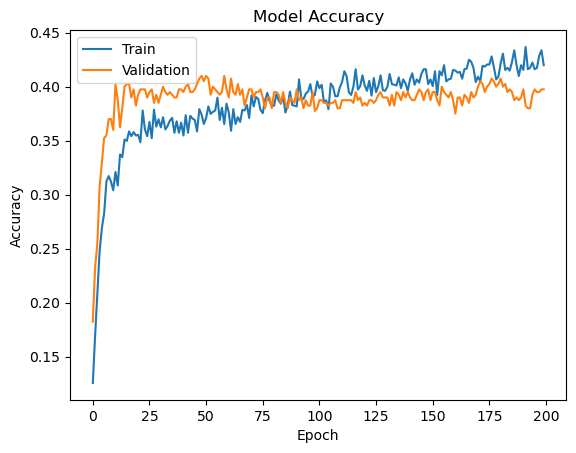

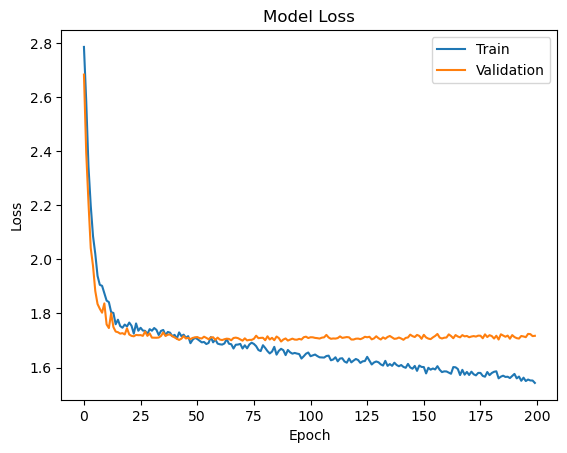

In [20]:
import matplotlib.pyplot as plt

# Assuming you have trained the model and stored the history in a variable named 'history'

# Plotting the training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [21]:
_, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

13/13 [==============================] - 0s 2ms/step - loss: 1.7174 - accuracy: 0.3975
Test accuracy: 0.39750000834465027


In [22]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Set the supported ops to TFLITE_BUILTINS and SELECT_TF_OPS
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ashen\AppData\Local\Temp\tmpodr4h0o2\assets


INFO:tensorflow:Assets written to: C:\Users\ashen\AppData\Local\Temp\tmpodr4h0o2\assets


In [24]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get the input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare the input data
for x in X_test:
    X_test1 = np.expand_dims(x, axis=0)  # Add a batch dimension if needed
    X_test1 = X_test1.astype(np.float32)  # Convert to FLOAT32

    # Set the input tensor
    input_tensor_index = input_details[0]['index']
    interpreter.set_tensor(input_tensor_index, X_test1)

    # Run the inference
    interpreter.invoke()

    # Get the output tensor
    output_tensor_index = output_details[0]['index']
    output = interpreter.get_tensor(output_tensor_index)

    # Perform post-processing if needed
    # predictions = np.argmax(output, axis=1)  # Get the predicted classes

    # Print the predictions
    print(encoder.inverse_transform(output))

[['Sniffing']]
[['Trotting']]
[['Sniffing']]
[['Pacing']]
[['Sitting']]
[['Standing']]
[['Standing']]
[['Bowing']]
[['Trotting']]
[['Jumping']]
[['Standing']]
[['Bowing']]
[['Jumping']]
[['Trotting']]
[['Walking']]
[['Drinking']]
[['Walking']]
[['Shaking']]
[['Standing']]
[['Drinking']]
[['Walking']]
[['Standing']]
[['Sitting']]
[['Bowing']]
[['Pacing']]
[['Walking']]
[['Walking']]
[['Standing']]
[['Drinking']]
[['Pacing']]
[['Jumping']]
[['Pacing']]
[['Walking']]
[['Sitting']]
[['Standing']]
[['Standing']]
[['Jumping']]
[['Sitting']]
[['Galloping']]
[['Galloping']]
[['Shaking']]
[['Pacing']]
[['Standing']]
[['Standing']]
[['Sitting']]
[['Drinking']]
[['Sitting']]
[['Trotting']]
[['Walking']]
[['Sitting']]
[['Sniffing']]
[['Galloping']]
[['Pacing']]
[['Shaking']]
[['Standing']]
[['Standing']]
[['Playing']]
[['Drinking']]
[['Galloping']]
[['Trotting']]
[['Bowing']]
[['Playing']]
[['Standing']]
[['Drinking']]
[['Standing']]
[['Bowing']]
[['Standing']]
[['Tugging']]
[['Shaking']]
[['Walki

In [25]:
encoder.inverse_transform(output)

array([['Sitting']], dtype=object)